---
## Imports
---

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

# Load train data
train_path = "/content/drive/MyDrive/Project Data/train.csv"
#train_path = "Project Data-20250507/train.csv"
train_df = pd.read_csv(train_path)

# View shape and features
print("Training data shape:", train_df.shape)
print("\nTraining data columns:", train_df.columns.tolist())

# Display first few rows
print("\nFirst 5 rows of training data:")
train_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data shape: (9543, 2)

Training data columns: ['text', 'label']

First 5 rows of training data:


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


---
## Set the seed for reproducibulity
---

In [18]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

---
## Text Cleaning
---
Roberta was trained on unprocessed data, therefore no text cleaning is necassary.

---
## Data split into train and validation
---

In [19]:
# Train and Test (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    train_df["text"], train_df["label"],
    test_size=0.2, stratify=train_df["label"], random_state=42
)

---
## Prepare hugging face DatasetDict
---
This stores data splits in an accessible way for other hugging face tools

In [20]:
dataset = DatasetDict({
    "train": Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()}),
    "test": Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})
})

---
## Use roberta tokenizer
---

In [21]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, max_length=64)

tokenized = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

---
## Show an example of a tweet: original and tokenized
---

In [22]:
# Show one example from the training set
sample = tokenized["train"][0]

# Decode the input_ids back into readable text
decoded_text = tokenizer.decode(sample["input_ids"])

# Display nicely
print("Original Text:")
print(dataset["train"][0]["text"])
print("\nTokenized Input IDs:")
print(sample["input_ids"])
print("\nDecoded (Recovered) Text:")
print(decoded_text)
print("\nAttention Mask:")
print(sample["attention_mask"])
print("\nLabel:")
print(sample["label"])

Original Text:
Nasdaq prices 600M of 0.875% senior notes

Tokenized Input IDs:
[0, 487, 281, 5946, 850, 5594, 448, 9, 321, 4, 29271, 207, 949, 2775, 2]

Decoded (Recovered) Text:
<s>Nasdaq prices 600M of 0.875% senior notes</s>

Attention Mask:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Label:
2


---
## Dynamic padding collator
---
Data collators are objects that will form a batch by using a list of dataset elements as input

In [23]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

---
## Compute metrics
---

In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
    }

---
## Training arguments
---

In [25]:
training_args = TrainingArguments(
    output_dir="./results/roberta_full",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs/roberta_full",
    report_to="none"
)

---
## Load model and trainer
---

In [26]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-26-8b9adb6f6efd>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


---
## Train the model
---

In [27]:
trainer.train()

Step,Training Loss
500,0.548100
1000,0.430800
1500,0.318600
2000,0.307700
2500,0.196500


TrainOutput(global_step=2865, training_loss=0.34106545439981456, metrics={'train_runtime': 554.1222, 'train_samples_per_second': 41.33, 'train_steps_per_second': 5.17, 'total_flos': 555225839679420.0, 'train_loss': 0.34106545439981456, 'epoch': 3.0})

---
## Evaluate on test
---

In [28]:
preds = trainer.predict(tokenized["test"])
y_pred = np.argmax(preds.predictions, axis=1)
y_true = np.array(tokenized["test"]["label"])

# Print classification report
report = classification_report(y_true, y_pred, digits=4)
print("Test Set Classification Report:\n")
print(report)

Test Set Classification Report:

              precision    recall  f1-score   support

           0     0.8123    0.8264    0.8193       288
           1     0.8490    0.8909    0.8695       385
           2     0.9389    0.9207    0.9297      1236

    accuracy                         0.9005      1909
   macro avg     0.8667    0.8793    0.8728      1909
weighted avg     0.9017    0.9005    0.9009      1909



---
## Confusion Matrix
---

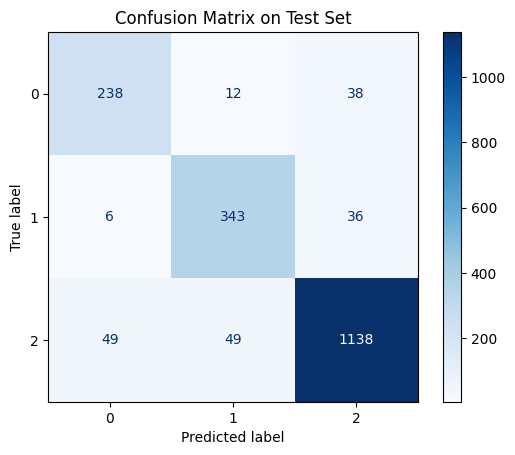

In [29]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()